In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

The full list of all the datasets stored inside torchvision.dataseets is [here](https://pytorch.org/vision/stable/datasets.html)

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f"Shape of [N, C, H, W] is: {X.shape}")
    print(f"Shape of y is: {y.shape}, {y.dtype}")    
    break

Shape of [N, C, H, W] is: torch.Size([64, 1, 28, 28])
Shape of y is: torch.Size([64]), torch.int64


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss ,correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308664  [    0/60000]
loss: 2.285754  [ 6400/60000]
loss: 2.270351  [12800/60000]
loss: 2.251966  [19200/60000]
loss: 2.219512  [25600/60000]
loss: 2.196196  [32000/60000]
loss: 2.208435  [38400/60000]
loss: 2.163903  [44800/60000]
loss: 2.169508  [51200/60000]
loss: 2.119273  [57600/60000]
Test Error: 
 Accuracy: 44.3%, Avg loss: 2.116209 

Epoch 2
-------------------------------
loss: 2.134595  [    0/60000]
loss: 2.116325  [ 6400/60000]
loss: 2.053075  [12800/60000]
loss: 2.069115  [19200/60000]
loss: 1.995301  [25600/60000]
loss: 1.937080  [32000/60000]
loss: 1.978947  [38400/60000]
loss: 1.880836  [44800/60000]
loss: 1.901382  [51200/60000]
loss: 1.813179  [57600/60000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.810833 

Epoch 3
-------------------------------
loss: 1.854402  [    0/60000]
loss: 1.813600  [ 6400/60000]
loss: 1.694706  [12800/60000]
loss: 1.735877  [19200/60000]
loss: 1.606613  [25600/60000]
loss: 1.581903  [32000/600

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved pytorch model state to model.pth")

Saved pytorch model state to model.pth


In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Tensors

In [14]:
import torch
import numpy as np

### Tensors intialization

Directly from data

In [15]:
data = [[1,2], [3,4]]
x_data = torch.tensor(data)

From numpy array

In [16]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

From other tensor

In [17]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.0855, 0.6891],
        [0.3589, 0.2847]]) 



With random or constant values

In [18]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.5843, 0.3900, 0.7514],
        [0.6764, 0.6643, 0.4065]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Operations on tensor

In [19]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## Full list - https://pytorch.org/docs/stable/torch.html

Slicing and indexing

In [20]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")

tensor[:,1] = 0

print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


### Joining the tensors

In [21]:
t1 = torch.ones(3,3)
t2 = torch.zeros(3,4)
t3 = torch.cat([t1, t2], dim=1)
t3

tensor([[1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.]])

In [22]:
t4 = torch.ones(3,4)
t5 = torch.stack([t2, t4], dim=0)
t5

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

### Arithmatic Opearations

Multiplication

In [23]:
t5 = torch.rand(3, 3)
multi1 = t1 @ t5.T
multi2 = t1.matmul(t5.T)
multi3 = torch.rand_like(t1)
torch.matmul(t1, t5.T, out=multi3)

print(multi1)
print(multi2)
print(multi3)

tensor([[2.0257, 1.1712, 2.2457],
        [2.0257, 1.1712, 2.2457],
        [2.0257, 1.1712, 2.2457]])
tensor([[2.0257, 1.1712, 2.2457],
        [2.0257, 1.1712, 2.2457],
        [2.0257, 1.1712, 2.2457]])
tensor([[2.0257, 1.1712, 2.2457],
        [2.0257, 1.1712, 2.2457],
        [2.0257, 1.1712, 2.2457]])


Sum

In [24]:
agg = t5.sum()
agg_item = agg.item()

print(agg)
print(agg_item)

tensor(5.4426)
5.442610740661621


In-place operations Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change x.

In [25]:
t5.add_(3)
t5

tensor([[3.5248, 3.6815, 3.8194],
        [3.5946, 3.3134, 3.2632],
        [3.7672, 3.5400, 3.9385]])

In [26]:
t7 = t5 + 3
t7

tensor([[6.5248, 6.6815, 6.8194],
        [6.5946, 6.3134, 6.2632],
        [6.7672, 6.5400, 6.9385]])

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

# Datasets and Dataloaders

### Loading dataset

In [27]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [28]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

### Visualizing dataset

In [29]:
import pandas as pd

In [30]:
# for i, j in training_data:
#     print(j)

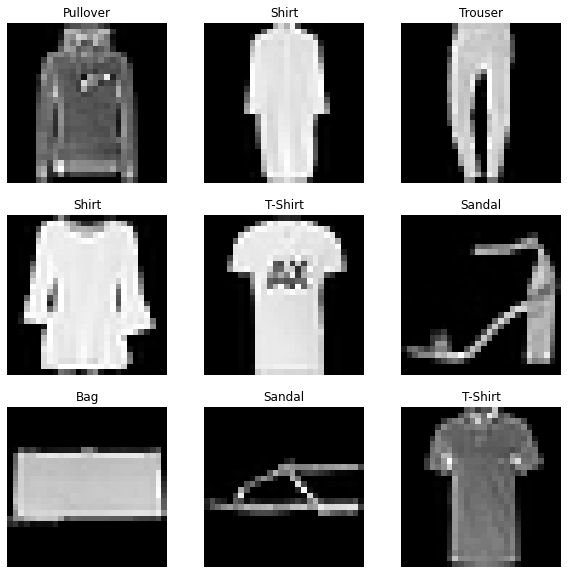

In [31]:
labels_map = {0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",}

figure = plt.figure(figsize = (10,10))
cols ,rows = 3, 3

for i in range (1, rows*cols+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Custom dataset

In [32]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Preparing your data for training with DataLoaders

In [33]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through dataset

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


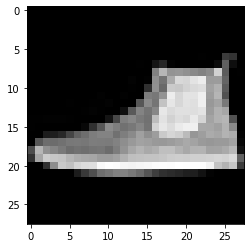

Label: 9


In [34]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#### For further reading - https://pytorch.org/docs/stable/data.html

# Transform for data manipulation

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. 